In [1]:
import sys
sys.path.append('/home/jannik/MA/fertige-MA/gitrepo')
from master_project import *

import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

from scipy.integrate import cumtrapz

lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work
Loaded NRSur7dq4Remnant fit.
Loaded NRSur7dq4 model


In [2]:
# fixed parameters
q = 1             # mass ratio
a = 0.8           # spin magnitude
t_ref = -100      # reference time (default for NRSur7dq4Remnant) 

## Master formula

In [3]:
# master formula at t_ref = -100 M in copr frame

def master_eq(q, chi1, chi2):
    
    # calculate surrogate waveform 
    t_ref = -100
    f_ref = get_f_ref(q, chi1, chi2, t_ref)
    t, h, dyn = sur(q, chi1, chi2, dt=dt, f_low=f_low, f_ref=f_ref) 
    h_copr = modes_from_iner_to_new_frame(t, h, 'coprecessing')
    
    # calculate +/- quantities
    a_a = ampl_asym(h_copr, 2, 2)
    phi_a = phi_asym(h_copr, 2, 2)
    a_s = ampl_sym(h_copr, 2, 2)
    phi_s = phi_sym(h_copr, 2, 2)
    
    # calculate derivates of +/- quantities
    a_a_dot = np.diff(a_a) / dt
    a_a_dot = np.append(a_a_dot[0], a_a_dot)
    phi_a_dot = np.diff(phi_a) / dt 
    phi_a_dot = np.append(phi_a_dot[0], phi_a_dot)
    a_s_dot = np.diff(a_s) / dt 
    a_s_dot = np.append(a_s_dot[0], a_s_dot)
    phi_s_dot = np.diff(phi_s) / dt 
    phi_s_dot = np.append(phi_s_dot[0], phi_s_dot)
    
    # Shrobana master eq. and integration
    term1 = (a_a_dot*a_s_dot + a_a*a_s*phi_a_dot*phi_s_dot)*np.cos(phi_a - phi_s)
    term2 = - (a_a*a_s_dot*phi_a_dot - a_a_dot*a_s*phi_s_dot)*np.sin(phi_a - phi_s) 
    dPzdt = 1/(6*np.pi) * (term1 + term2)
    Pz = simps(dPzdt, dx=dt)
    Pzt = cumtrapz(dPzdt, t, initial=0)
    
    return t, a_a, phi_a, a_s, phi_s, a_a_dot, a_s_dot, phi_a_dot, phi_s_dot, term1, term2, dPzdt, Pz, Pzt

## $\alpha$ variation

In [4]:
n = 2**10

alphas = np.linspace(0., 2*np.pi, n)

# phase diffs at t=9M
phase_diffs = []

# dominant term integral
term_int = []

# kick velocities NRSur7dq4
vs = [] 

# kick velocities master formula
Pzs = []

# loop over in-plane spin angle
for alpha in alphas:
    
    # chi1 and chi2 always anti-aligned and rotated both counterclockwise
    chi1x = np.cos(alpha) * a
    chi1y = np.sin(alpha) * a
    chi1z = 0
    chi1 = [chi1x, chi1y, chi1z]
    chi2 = [-chi1x, -chi1y, -chi1z]

    # master eq
    t, a_a, phi_a, a_s, phi_s, a_a_dot, a_s_dot, phi_a_dot, phi_s_dot, term1, term2, dPzdt, Pz, Pzt = master_eq(q, chi1, chi2)
    
    # phase diffs
    t_max = 9 
    i_max = np.argmin(np.abs(t - t_max))
    phim_phip = (phi_a - phi_s)[i_max]
    phase_diffs.append(phim_phip)
    
    # kick velocities  
    term = a_a*a_s*phi_a_dot*phi_s_dot
    term_int.append(simps(term, dx=dt))  
    vf, vf_err = fit.vf(q, chi1, chi2) 
    vs.append(vf[2])
    Pzs.append(Pz)  
    
phase_diffs = np.array(phase_diffs) 
term_int = np.array(term_int)*3*10**5/(6*np.pi)
vs = np.array(vs)*3*10**5
Pzs = -np.array(Pzs)*3*10**5

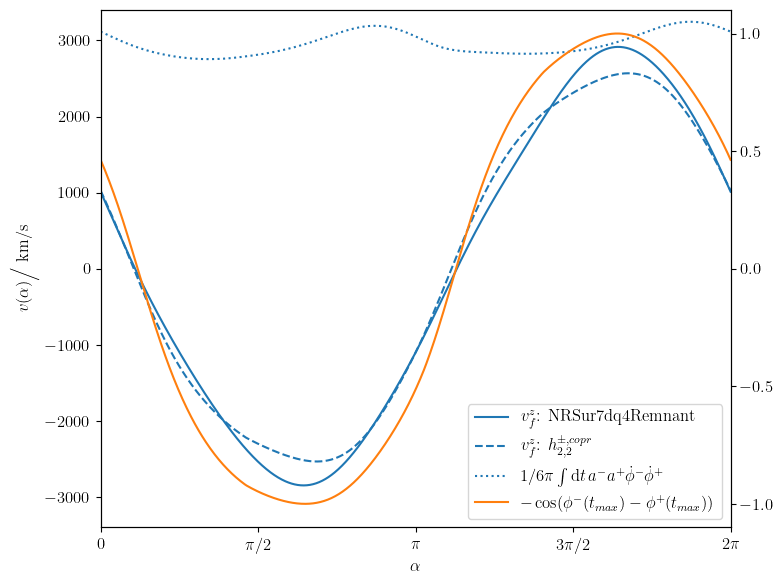

In [7]:
fig, ax1 = plt.subplots()  

color = 'tab:blue'
ax1.set_ylabel(r'$v(\alpha)$\Big/ km/s')  
lns1 = ax1.plot(alphas, vs, color = color, 
                label=r'$v^z_f$: NRSur7dq4Remnant') 
lns2 = ax1.plot(alphas, Pzs,'--', color = color, 
                label=r'$v^z_f$: $h_{2,2}^{\pm,copr}$') 
lns3 = ax1.plot(alphas, term_int,':', color = color, 
                label=r'$1/6\pi \int\mathrm{d}t \,a^- a^+ \dot{\phi}^- \dot{\phi}^+$')    
ax1.set_xticks(np.arange(0, 2*np.pi+np.pi/2, step=(np.pi/2)), ['0',r'$\pi$/2',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylim(-3400,3400)
ax1.set_xlim(0,2*np.pi)

ax2 = ax1.twinx()     
lns4 = ax2.plot(alphas, -np.cos(phase_diffs), color = 'tab:orange', 
                label=r'$-\cos(\phi^-(t_{max}) - \phi^+(t_{max}))$')   
ax2.set_yticks([-1,-0.5,0,0.5,1])

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()
#fig.savefig('alpha_kick.pdf')
plt.show()